# Introduction

This notebook contains the code to train and evaluate an ensemble of neural networks on the [WILDS Poverty Map](https://wilds.stanford.edu/datasets/#povertymap) dataset.

Python packages used in this notebook
- [Pytorch](https://pytorch.org/)
- [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/)
- numpy/pandas/scikit-learn

**This notebook assumes that you have access to a Nvidia GPU that supports cuda.**

## Read training set

All image files are stored as `npz` files in `/datasets/cs255-sp22-a00-public/poverty/anon_images` on datahub, which you can directly read by calling [`numpy.load`](https://numpy.org/doc/stable/reference/generated/numpy.load.html). 

We have already divided all images into a training set and two test sets. 
- `train.csv`: the training images.
- `random_test_reduct.csv`: the test images, whose countries have all appeared in the trianing set. 
- `country_test_reduct.csv`: the test images, whose countries have NOT appeared in the training set. 

Testing on `country_test_reduct.csv` should be a harder task than testing on `random_test_reduct.csv` because the images in different countries are not supposed to be in the same distributions. 

**In this notebook, we only test on `random_test_reduct.csv`.**

In [1]:
import pandas as pd

train_csv_path = '../../public_tables/train.csv'
test_csv_path = '../../public_tables/random_test_reduct.csv'
image_path = '/datasets/cs255-sp22-a00-public/poverty/anon_images'

train_csv_df = pd.read_csv(train_csv_path, index_col=0)
train_csv_df

,filename,country,wealthpooled,urban,label,nl_mean
0,image14517.npz,6,-1.019361,False,0,-0.086633
2,image7407.npz,6,-1.143002,False,0,-0.141589
3,image390.npz,6,1.056769,True,0,15.228898
4,image7980.npz,6,1.454064,True,1,11.082343
5,image13397.npz,6,1.708446,True,1,12.646744
...,...,...,...,...,...,...
19659,image13328.npz,8,0.047057,False,1,-0.216885
19661,image2309.npz,8,0.244931,False,1,-0.207048
19662,image16557.npz,8,0.952855,False,1,-0.202403
19665,image4238.npz,8,1.268232,True,0,0.895127


## Define Pytorch Dataloader

A dataloader is iterator over a datset that generates a batch of instances with labels in each iteration. 

Here we defines the Pytorch dataloader using

- [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
- [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
- [`pytorch_lightning.LightningDataModule`](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html)

The classes we defined here are:
- `WildsDataset`: defines how each image is read from the disk (`__getitem__` function).
- `BootstrapDM`: defines train and validation dataloaders (`__init__` function). This is a Pytorch Lightning wrapper over the traditional Pytorch dataloaders. 

In the `__init__` functions in `BootstrapDM` class, we randomly split the training instances into training instances and validation instances and only train the model on the newly splitted training instances. This is important since bootstrap requries that each model in the ensemble should be trained on slightly different training instances. 

In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

class WildsDataset(Dataset):    
    def __init__(self, image_paths, idx_to_class=None, transform=None):
        self.image_paths = image_paths
        self.idx_to_class = idx_to_class
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = np.load(self.image_paths[idx])
        image = image.f.x

        if self.transform:
            image = self.transform(image)
            
        if self.idx_to_class:
            index = self.image_paths[idx].split('/')[-1]
            label = self.idx_to_class[index]
        else:
            return image
            
        return image, label

class BootstrapDM(pl.LightningDataModule):
    def __init__(self, csv_path, image_path, batch_size=200, train_val_split_ratio=0.5):
        super().__init__()
        
        self.csv_path = csv_path
        self.image_path = image_path
        self.batch_size = batch_size
        self.train_val_split_ratio = train_val_split_ratio
        
        # Read metadata csv for all images
        csv_df = pd.read_csv(self.csv_path, index_col=0)
        
        # Get a bootstrap iteration (get train and valid indices)
        csv_rows = csv_df.loc[:, ['filename', 'label']].to_dict(orient='records')
        train_indices, valid_indices = train_test_split(range(len(csv_rows)), train_size=self.train_val_split_ratio)
        
        # Get train and valid image paths
        train_image_paths = [os.path.join(self.image_path, csv_rows[index]['filename']) for index in train_indices]
        valid_image_paths = [os.path.join(self.image_path, csv_rows[index]['filename']) for index in valid_indices]

        image_label = {x['filename']: x['label'] for x in csv_rows}
        self.train_dataset = WildsDataset(train_image_paths, image_label)
        self.val_dataset = WildsDataset(valid_image_paths, image_label)
    
    def train_dataloader(self):
        loader = DataLoader(self.train_dataset, batch_size=self.batch_size)
        return loader
    
    def val_dataloader(self):
        loader = DataLoader(self.val_dataset, batch_size=self.batch_size)
        return loader

## Define neural network stucture, loss function and training parameters

We chose to use the smallest [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/) (resnet18) implemented in Pytorch as the structure of the neural network. 

We also defined a Pytorch Lightning wrapper (`baseline_module`) of the network. In `baseline_module`, we defined several hyper-parameters that are related to the training process:
- Learning rate `self.lr`: 1e-3.
- weight decay (l2 regularization) `self.weight_decay`: 1e-4.
- loss function `self.loss`: [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
- optimizer `configure_optimizers`: vanilla [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) with momentum=0.9.

In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics.functional import accuracy

from resnet import *

class baseline_module(pl.LightningModule):
    def __init__(self, lr=1e-3, weight_decay=1e-4):
        super().__init__()
        self.model = ResNet18(num_classes=2, num_channels=8)
        self.loss = nn.CrossEntropyLoss()
        self.lr = lr
        self.weight_decay = weight_decay
        
        self.save_hyperparameters()

    def forward(self, x):
        out = self.model(x)

        return out

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.weight_decay, momentum=0.9)
        return {'optimizer': optimizer}

    def single_step(self, batch, batch_idx):
        x, y = batch
        y = y.long()

        y_hat_scores = self(x)
        _, y_hat = torch.max(y_hat_scores, 1)

        loss = self.loss(y_hat_scores, y)
        acc = accuracy(y_hat, y)

        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.single_step(batch, batch_idx)

        self.log('tloss', loss, on_epoch=True, on_step=False, logger=True, prog_bar=True)
        self.log('tacc', acc, on_epoch=True, on_step=False, logger=True, prog_bar=True)

        return loss
        
    def validation_step(self, batch, batch_idx):
        loss, acc = self.single_step(batch, batch_idx)

        self.log('vloss', loss, on_epoch=True, on_step=False, logger=True, prog_bar=True)
        self.log('vacc', acc, on_epoch=True, on_step=False, logger=True, prog_bar=True)

        return loss
 
    def test_step(self, batch, batch_idx):
        loss, acc = self.single_step(batch, batch_idx)

        self.log('test_loss', loss, on_epoch=True, on_step=False, logger=True, prog_bar=True)
        self.log('test_acc', acc, on_epoch=True, on_step=False, logger=True, prog_bar=True)

        return loss

## Training 

Here we start to train the ensemble of the networks. Important variables in the cell:
- `num_epochs`: adjust how many epochs we want the network to be trained.
- `num_bootstraps`: adjust how many networks are in the ensembles.
- `save_folder`: the path to the directory where the models will be saved. Use `None` to disable model saving. 
- `models`: the list of the network models in the ensemble.

Again, the training code of the network (forward-propagation, backward-propagation, and loss evaluation) are all taken cared by Pytorch Lighting package (`trainer.fit`). Please go to the documents of the Pytorch Lighting package if you want to know details.

**Training time**:

Use the default hyper-parameters, it is estimated to take around 2 mins for 1 epoch. Thus training 10 networks with 20 epochs takes 2 * 20 * 10 = 400 mins = 6.6 hours.

In [14]:
import argparse
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning.callbacks import ModelCheckpoint

parser = argparse.ArgumentParser()
parser = BootstrapDM.add_argparse_args(parser)
args = parser.parse_args("")

save_folder = "bootstraps2"
num_epochs = 20
num_bootstraps = 10

models = []
trainers = []
for i in range(num_bootstraps):
    trainer = pl.Trainer(
        gpus=1, accelerator='gpu', max_epochs=num_epochs, precision=16,
        strategy=DDPPlugin(find_unused_parameters=False),
    )

    model = baseline_module()
    dm = BootstrapDM(train_csv_path, image_path)
    trainer.fit(model, datamodule=dm)
    if save_folder:
        trainer.save_checkpoint(os.path.join(save_folder, f"bootstrap{i}.ckpt"))
    
    models.append(model)
    trainers.append(trainer)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet18         | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
22.386    Total estimated model params size (MB)


5682 5683


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet18         | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
22.386    Total estimated model params size (MB)


5682 5683


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


KeyboardInterrupt: 

### Or load pre-trained models

`load_folder`: the path to the directory where the models will be loaded.

### WARNNING: executing this cell will overwrite `models`. If you have unsaved trained `models`, save them first before executing the cell below.

In [4]:
import os
    
# load_folder = save_folder
load_folder = "bootstraps"

models = []
if load_folder:
    model_files = sorted([file for file in os.listdir(load_folder) if file.split('.')[1] == 'ckpt'])
    for file in model_files:
        models.append(baseline_module.load_from_checkpoint(checkpoint_path=os.path.join(load_folder, file)))
    
print(f'{len(models)} models loaded')

10 models loaded


## Testing

Here we evaluate our ensemble of trained networks on the test set. Again we need to load the test dataset from the disk. However, this time we used standard `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` (no use of the wrapper `pytorch_lightning.LightningDataModule`) to show you how the test data is loaded.

The outputs of the network models are stored in two dicts, both of which have the filename as keys and each value is:
- `name_labels_nn`: a list of `num_bootstraps` number of predictions (0 or 1) from each model.
- `name_scores_nn`: a list of `num_bootstraps` number of outputs (real value between 0 and 1) for label 1 from each model.

In [5]:
import ntpath
import collections
from tqdm import tqdm

test_csv_df = pd.read_csv(test_csv_path, index_col=0)
test_image_paths = [os.path.join(image_path, row['filename']) for index, row in test_csv_df.iterrows()]
    
test_batch_size = 100
test_dataset = WildsDataset(test_image_paths)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

test_image_names = list(map(lambda x: ntpath.basename(x), test_image_paths))

name_labels_nn = collections.defaultdict(list)
name_scores_nn = collections.defaultdict(list)
for batch_index, batch in tqdm(enumerate(test_loader)):
    start_index = batch_index * test_batch_size
    
    for model in models:
        model = model.to('cuda')
        batch = batch.to('cuda')

        output = model(batch)
        logits = output.softmax(dim=1)
        scores = logits[:, 1]
        preds = logits.argmax(dim=1)

        for pred_index, pred in enumerate(preds):
            name_labels_nn[test_image_names[start_index + pred_index]].append(pred.item())
            
        for score_index, score in enumerate(scores):
            name_scores_nn[test_image_names[start_index + score_index]].append(score.item())

38it [01:35,  2.50s/it]


### To predict or to abstain

Here we used the outputs from the ensemble of the models to decide the final labels of the test set. The strategy is that we should abstain (do not predict) if we don't have enough confidence of the prediction. 
- We take the average of either the scores or the labels from the network models in the ensemble as the final score of predicting label 1.
- If the score is above `threshold` or below 1 - `threshold`, then we can predict with confidence that the label should be positive (predict 1) or negative (predict -1). 
- However, if the score is between `threshold` and 1 - `threshold`, then we should abstain (predict 0).

In [14]:
def get_preds(threshold=0.6, use_score=True):
    name_preds = []
    for index, row in test_csv_df.iterrows():
        filename = row['filename']
        if use_score:
            mean_output = np.mean(name_scores_nn[filename])
        else:
            mean_output = np.mean(name_labels_nn[filename])

        if mean_output >= threshold:
            pred = 1
        elif mean_output <= 1 - threshold:
            pred = -1
        else:
            pred = 0
        
        pred_accu = 1 if mean_output > 0.5 else -1
        name_preds.append([filename, pred, pred_accu])
    preds_df = pd.DataFrame(name_preds, columns=['filename', 'label', 'label_accuracy'])
    
    return preds_df
        
preds_df = get_preds()
outputs_df = test_csv_df[['filename', 'urban']].merge(preds_df, on='filename')
outputs_df = outputs_df.astype({'urban': int})
outputs_df.to_csv('results.csv')
outputs_df

,filename,urban,label,label_accuracy
0,image13724.npz,0,0,-1
1,image19338.npz,1,0,1
2,image19053.npz,1,1,1
3,image12371.npz,0,-1,-1
4,image19639.npz,0,-1,-1
...,...,...,...,...
3783,image9142.npz,0,0,-1
3784,image7755.npz,0,0,-1
3785,image13002.npz,1,0,-1
3786,image14642.npz,1,0,1


## Upload your predictions

You can directly upload the saved file `results.csv` to gradescope to see how your models perform.

### Statistics of the pretrained models

Using the average scores of neural network ensembles, we get:

- Classification accuracy: 0.57
- Assymetric loss using threshold = 0.7 and alpha = 2: -0.0184
- Score distribution:
    ![image](score_distribution.png)

# END for students

### Read ground truth labels from `data_table.csv`

In [22]:
all_df = pd.read_csv('../../tables/data_table.csv', index_col=0)
all_df = all_df.loc[:, ['filename', 'label']]

labels = []
for index, row in test_csv_df.iterrows():
    filename = row['filename']
    label = all_df[all_df['filename'] == filename]['label'].item()
    labels.append(1 if label == 1 else -1)
labels = np.array(labels)

### Classification accuracy

In [33]:
preds_df = get_preds(threshold=0.5)
results = preds_df['label'].to_numpy() * labels
results[results == -1] = 0
print(f'The classification accuracy is {results.mean()}')

The classification accuracy is 0.5704857444561774


### Assymetric loss

Using `threshold = 0.7` and `alpha = 2`. 

In [32]:
alpha = 2
threshold = 0.7

preds_df = get_preds(threshold=threshold)
results = preds_df['label'].to_numpy() * labels
results[results == -1] = results[results == -1] * alpha
results.mean()
print(f'The assymetric loss score is {results.mean()}')

The assymetric loss score is -0.018479408658922915


### score distribution

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy import *
import pandas as pd
import pickle as pkl

def plot_scores(styled_logs,title=None,normalize=True, check=False):
    """
    """
    if check:
        check_styled_logs(styled_logs)
        
    plt.figure(figsize=(8, 6))

    patches=[]
    for st_log in styled_logs:
        style=st_log['style']
        log=st_log['log']
        
        #find normalization constants
        if normalize:
            all_pred=[]
            for i in range(len(log)):
                X=log[i]
                y_pred=X['y_pred']
                all_pred.append(y_pred)
            all_pred=concatenate(all_pred)
            _mean=mean(all_pred)
            _std=std(all_pred)
        else:
            _mean=0
            _std=1

        for i in range(len(log)):
            X=log[i]
            y_pred=X['y_pred']
            y_test=X['y_test']
            y_pred=(y_pred-_mean)/_std
            thresholds = sorted(unique(np.round(y_pred, 2)))
            error_pos, error_neg = get_error_values(y_pred, y_test, thresholds)
            neg_line, = plt.plot(thresholds,error_neg,style[0],lw=0.5)
            pos_line, = plt.plot(thresholds,error_pos,style[1],lw=0.5)
        patch = mpatches.Patch(color=st_log['label_color'], label=st_log['label'])
        patches.append(patch)
    plt.grid(linestyle='-', linewidth='0.5', color='gray')
    plt.xlabel('Score')
    plt.ylabel('Error %')

    plt.legend(handles=patches)
    if title:
        plt.title(title)


def check_styled_logs(styled_logs):
    
    i=0
    for X in styled_logs:
        for k in ['log', 'style', 'label', 'label_color']:
            assert k in X
        print(f'checking item {i}, label={X["label"]}')
        i+=1
        assert type(X['label'])==str
        assert type(X['label_color'])==str
        style=X['style']
        assert type(style)==list
        for st in style:
            assert type(st)==str
        Log=X['log']

        for l in Log:
            y_pred=l['y_pred']
            y_test=l['y_test']

            assert y_pred.shape== y_test.shape
            assert y_pred.dtype==dtype('float32')
            assert y_test.dtype==dtype('int8')

def get_error_values(y_pred, y_test, thresholds):
    accuracy_1 = []
    accuracy_0 = []
    for thresh in thresholds:
        y_test_i = y_test[y_test == 1]
        y_pred_i = y_pred[y_test == 1]
        correct = sum(y_pred_i > thresh)
        accuracy_1.append(1.0 * correct / len(y_test_i))

        y_test_i = y_test[y_test == 0]
        y_pred_i = y_pred[y_test == 0]
        correct = sum(y_pred_i <= thresh)
        accuracy_0.append(1.0 * correct / len(y_test_i))
    
    error_1 = list(1 - array(accuracy_1))
    error_0 = list(1 - array(accuracy_0))
    return error_1, error_0

In [30]:
y_preds = []
for index, row in test_csv_df.iterrows():
    filename = row['filename']
    y_preds.append(np.array(name_scores_nn[filename]))
y_preds = np.array(y_preds)

y_test = labels.copy()
y_test[y_test == -1] = 0

nn_logs = []
for i in range(y_preds.shape[1]):
    nn_logs.append({'y_pred': y_preds[:, i], 'y_test': y_test})

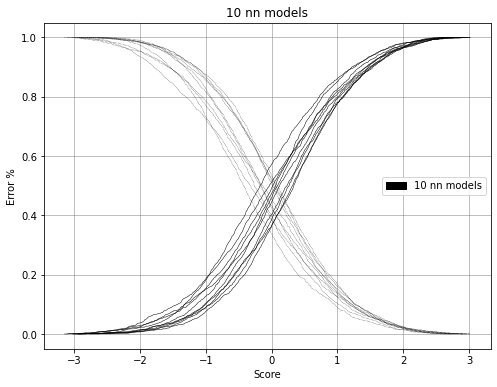

In [31]:
styled_logs=[
    {   'log':nn_logs,
        'style':['k:','k-'],
        'label':'10 nn models',
        'label_color':'k'
    },
]
plot_scores(styled_logs,title='10 nn models')